In [ ]:
%pip install python-terrier

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Alime\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import pyterrier as pt
from pyterrier.measures import *
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Initialize PyTerrier
if not pt.started():
    pt.init()

# Load data
df = pd.read_csv("Final.csv")
df['docno'] = df.index.astype(str)
docs = df[['docno', 'text']]

# Ensure index path is valid and outside of restricted folders
index_path = os.path.abspath("reddit_index")
os.makedirs(index_path, exist_ok=True)

# Indexing
indexer = pt.DFIndexer(index_path, overwrite=True)
index_ref = indexer.index(docs["text"], docs["docno"])

C:\Users\Alime\AppData\Local\Temp\ipykernel_8656\3289743011.py:2: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():
C:\Users\Alime\AppData\Local\Temp\ipykernel_8656\3289743011.py:15: DeprecationWarning: Call to deprecated class DFIndexer. (use pt.terrier.IterDictIndexer().index(dataframe.to_dict(orient='records')) instead) -- Deprecated since version 0.11.0.
  indexer = pt.DFIndexer(index_path, overwrite=True)


16:25:50.520 [main] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (289) - further warnings are suppressed
16:26:12.231 [main] WARN org.terrier.structures.indexing.Indexer -- Indexed 207 empty documents
16:26:12.233 [main] ERROR org.terrier.structures.indexing.Indexer -- Could not rename index
java.io.IOException: Rename of index structure file 'c:\Users\Alime\OneDrive\Desktop\Indexing_Search\reddit_index/data_1.direct.bf' (exists) to 'c:\Users\Alime\OneDrive\Desktop\Indexing_Search\reddit_index/data.direct.bf' (exists) failed - likely that source file is still open. Possible indexing bug?
	at org.terrier.structures.IndexUtil.renameIndex(IndexUtil.java:379)
	at org.terrier.structures.indexing.Indexer.index(Indexer.java:388)
	at org.terrier.structures.indexing.Indexer.index(Indexer.java:355)


In [ ]:
# Load the index
index = pt.IndexFactory.of(index_ref)



In [ ]:
# Define retrieval models
retrievers = {
    "BM25": pt.BatchRetrieve(index, wmodel="BM25"),
    "TF-IDF": pt.BatchRetrieve(index, wmodel="TF_IDF"),
    "PL2": pt.BatchRetrieve(index, wmodel="PL2")
}


C:\Users\Alime\AppData\Local\Temp\ipykernel_8656\3979611552.py:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  "BM25": pt.BatchRetrieve(index, wmodel="BM25"),
C:\Users\Alime\AppData\Local\Temp\ipykernel_8656\3979611552.py:4: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  "TF-IDF": pt.BatchRetrieve(index, wmodel="TF_IDF"),
C:\Users\Alime\AppData\Local\Temp\ipykernel_8656\3979611552.py:5: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  "PL2": pt.BatchRetrieve(index, wmodel="PL2")


In [ ]:
# Input query
query = "Charity"

# Collect results from all models
all_results = []

for model_name, retriever in retrievers.items():
    results = retriever.search(query)
    results["model"] = model_name
    all_results.append(results[["docno", "score", "model"]])

# Combine results
combined = pd.concat(all_results).reset_index(drop=True)

# Merge with original text
combined["docno"] = combined["docno"]
combined = combined.merge(df[["docno", "text"]], on="docno")

# Rank within each model
combined["rank"] = combined.groupby("model")["score"].rank(method="first", ascending=False).astype(int)

# Sort results for display
combined.sort_values(by=["model", "rank"], inplace=True)

# Select columns to display
display_columns = ["model", "rank", "score", "docno", "text"]

# Print results nicely
print("🔍 Keyword Search Results by Model:")
print(combined[display_columns].to_string(index=False, max_colwidth=100))

🔍 Keyword Search Results by Model:
 model  rank     score docno                                                                                                 text
  BM25     1 17.645646 21209                                                                  charity barely talked to him before
  BM25     2 17.645646 22063                                              why should it be discounted she’s not running a charity
  BM25     3 17.645646 40576                                                     so not different from donations to a charity org
  BM25     4 17.009311  4766                                                                    great charity work you doing here
  BM25     5 14.865064  7941 and remember this is from less than half his original shareshe has donated more than of his berks...
  BM25     6 13.581015  1384 in the us charitable donations must be only to registered charitie such an organization will have...
  BM25     7 12.841512  7463 the annual salary of the c

# Evaluation

### Let's Make some Relevance Labels For judgment

In [ ]:
# Define sample queries (you can extend or load from a list)
queries_dict = {
    "stock market": ["stock", "stocks", "market", "equity", "share price", "index", "nasdaq", "s&p"],
    "cryptocurrency": ["crypto", "bitcoin", "ethereum", "blockchain", "wallet", "token", "altcoin"],
    "inflation": ["inflation", "cpi", "consumer price", "cost of living", "price hike"],
    "interest rates": ["interest rate", "fed", "central bank", "hike", "cut", "monetary policy"],
    "recession": ["recession", "economic slowdown", "gdp", "unemployment", "layoff"],
    "personal finance": ["savings", "budget", "debt", "mortgage", "credit card", "loan"],
    "banking": ["bank", "account", "transfer", "atm", "fees", "overdraft"],
    "investment": ["invest", "portfolio", "fund", "mutual fund", "etf", "asset allocation"],
    "finance news": ["bloomberg", "financial times", "cnbc", "earnings report", "forecast"],
    "job market": ["job", "employment", "salary", "hiring", "career", "resume"]
}

# Convert to list of query rows
query_rows = []
for i, (topic, terms) in enumerate(queries_dict.items(), start=1):
    qid = str(i)
    query = " ".join(terms)  # Join the terms into a single string
    query_rows.append({"qid": qid, "query": query})

# Create DataFrame
queries_df = pd.DataFrame(query_rows)

# Save to CSV
queries_df.to_csv("queries.csv", index=False)
print("Saved to queries.csv")

# Build qrels from actual matches
qrels = []

for qid, (query, keywords) in enumerate(queries_dict.items(), start=1):
    for idx, row in df.iterrows():
        text = str(row["text"]).lower()
        if any(re.search(rf"\b{kw}\b", text) for kw in keywords):
            qrels.append({
                "qid": str(qid),
                "query": query,
                "docno": row["docno"],
                "label": 1
            })

# Convert to DataFrame
qrels_df = pd.DataFrame(qrels)


# For each query, randomly pick documents without keyword matches
import random
relevant_docnos = set(qrels_df["docno"])
all_docnos = set(df["docno"])
non_relevant_candidates = list(all_docnos - relevant_docnos)

for qid in range(1, len(queries_dict)+1):
    sampled = random.sample(non_relevant_candidates, min(10, len(non_relevant_candidates)))
    for docno in sampled:
        qrels_df = pd.concat([
            qrels_df,
            pd.DataFrame([{
                "qid": str(qid),
                "query": list(queries_dict.keys())[qid-1],
                "docno": docno,
                "label": 0
            }])
        ])

# Save to CSV
qrels_df.to_csv("realistic_qrels.csv", index=False)

# Preview
print(qrels_df.head(10))

Saved to queries.csv
  qid         query docno  label
0   1  stock market     4      1
1   1  stock market    10      1
2   1  stock market    15      1
3   1  stock market    16      1
4   1  stock market    22      1
5   1  stock market    27      1
6   1  stock market    42      1
7   1  stock market    60      1
8   1  stock market    64      1
9   1  stock market    65      1


### Now, We Can Evaluate

In [ ]:
queries = pd.read_csv("queries.csv")
qrels = pd.read_csv("realistic_qrels.csv", sep=",")  # or use sep="\t" if needed

# Create the retrieval models
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF", verbose=True)
bm25 = pt.BatchRetrieve(index, wmodel="BM25", verbose=True)
# Convert the 'qid' column to the same type (int or str) in both DataFrames

qrels['qid'] = qrels['qid'].astype(str)
queries['qid'] = queries['qid'].astype(str)
qrels['docno'] = qrels['docno'].astype(str)

C:\Users\Alime\AppData\Local\Temp\ipykernel_8656\785525901.py:9: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF", verbose=True)
C:\Users\Alime\AppData\Local\Temp\ipykernel_8656\785525901.py:10: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  bm25 = pt.BatchRetrieve(index, wmodel="BM25", verbose=True)


In [ ]:
# Evaluate

print("TF-IDF Evaluation:")
tfidf_eval = pt.Experiment(
    [tfidf],
    queries,
    qrels,
    eval_metrics=["map", "ndcg", "recip_rank"],
    names=["TF-IDF"]
)
print(tfidf_eval)

print("\nBM25 Evaluation:")
bm25_eval = pt.Experiment(
    [bm25],
    queries,
    qrels,
    eval_metrics=["map", "ndcg", "recip_rank"],
    names=["BM25"]
)
print(bm25_eval)


TF-IDF Evaluation:


TerrierRetr(TF_IDF): 100%|██████████| 10/10 [00:00<00:00, 50.93q/s]


     name       map      ndcg  recip_rank
0  TF-IDF  0.381766  0.532131         1.0

BM25 Evaluation:


TerrierRetr(BM25): 100%|██████████| 10/10 [00:00<00:00, 50.34q/s]

   name       map      ndcg  recip_rank
0  BM25  0.384076  0.534821         1.0


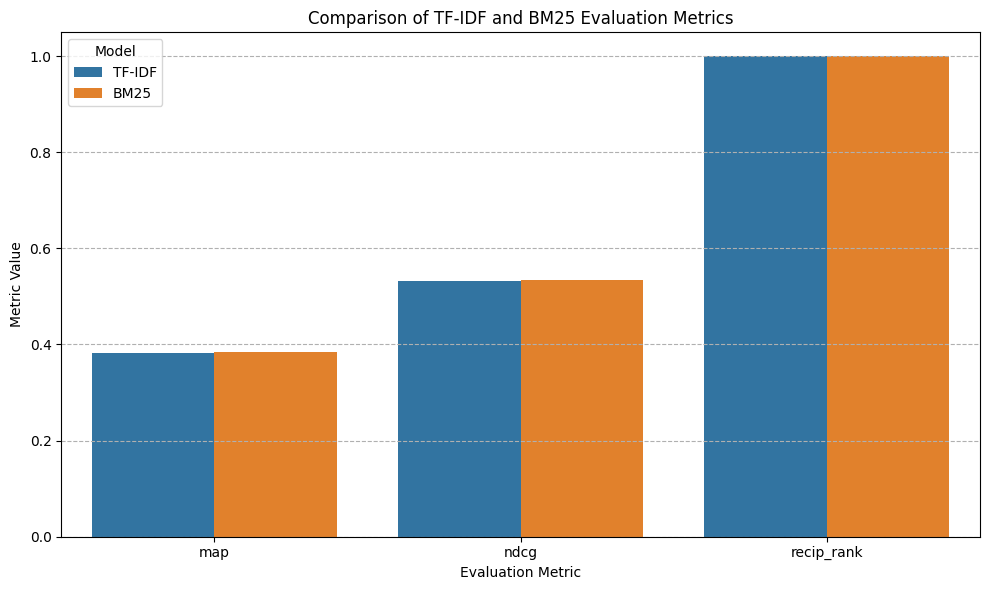

In [ ]:
comparison_df = pd.concat([tfidf_eval, bm25_eval]).melt(
    id_vars='name', var_name='metric', value_name='value'
)

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='metric', y='value', hue='name', data=comparison_df)
plt.title('Comparison of TF-IDF and BM25 Evaluation Metrics')
plt.ylabel('Metric Value')
plt.xlabel('Evaluation Metric')
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# PIPELINE VS SINGLE

In [ ]:
tf = pt.BatchRetrieve(index, wmodel="Tf")

C:\Users\Alime\AppData\Local\Temp\ipykernel_8656\3310907208.py:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tf = pt.BatchRetrieve(index, wmodel="Tf")


In [ ]:

evals= pt.Experiment(
  [tf,tfidf,bm25, bm25 >> tfidf ,tfidf >> bm25, ((tf % 500) | (tfidf % 500)) >> bm25],
  queries,
  qrels,
  eval_metrics=["map", "ndcg"],
  names=["TF","TF-IDF","BM25","BM25 >> TF-IDF" ,"TF-IDF >> BM25", "((TF % 10) | (TF-IDF % 10)) >> BM25"]
)


TerrierRetr(BM25): 100%|██████████| 10/10 [00:00<00:00, 54.42q/s]


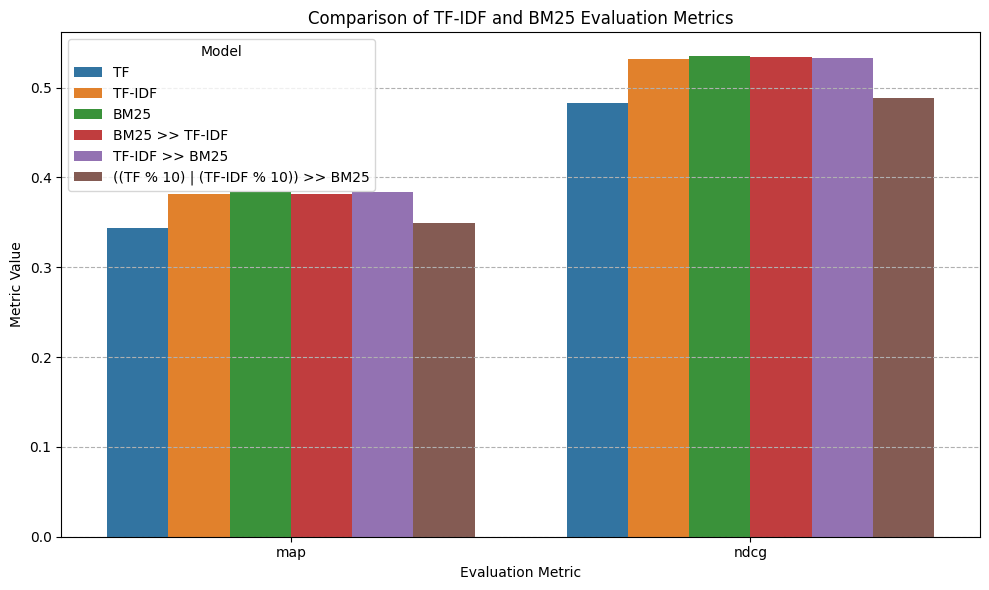

In [ ]:
comparison_df = pd.concat([evals]).melt(
    id_vars='name', var_name='metric', value_name='value'
)

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='metric', y='value', hue='name', data=comparison_df)
plt.title('Comparison of TF-IDF and BM25 Evaluation Metrics')
plt.ylabel('Metric Value')
plt.xlabel('Evaluation Metric')
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()